In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import NearestNeighbors

In [2]:
df = pd.read_csv("preprocessing\dataset_plantae_rj.csv", sep=";", encoding="latin1", dtype=str)
df_sem_duplicatas = df.drop_duplicates(subset=['nome_cientifico', 'latitude', 'longitude'])

print(f"Arquivo sem duplicatas salvo com {len(df_sem_duplicatas)} linhas.")
print(f"Arquivo com duplicatas tinha {len(df)} linhas.")
print(f"Removidas {len(df) - len(df_sem_duplicatas)} linhas duplicadas.")

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Caio Cadete\AppData\Local\Temp\ipykernel_26968\234475788.py:1: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv("preprocessing\dataset_plantae_rj.csv", sep=";", encoding="latin1", dtype=str)


Arquivo sem duplicatas salvo com 77246 linhas.
Arquivo com duplicatas tinha 94075 linhas.
Removidas 16829 linhas duplicadas.


In [3]:
df_sem_duplicatas.to_csv("preprocessing\dataset_plantae_rj_sem_duplicatas.csv", index=False, sep=';', encoding='latin1')

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Caio Cadete\AppData\Local\Temp\ipykernel_26968\4138988925.py:1: SyntaxWarning: invalid escape sequence '\d'
  df_sem_duplicatas.to_csv("preprocessing\dataset_plantae_rj_sem_duplicatas.csv", index=False, sep=';', encoding='latin1')


In [4]:
contagem_especies = df["nome_cientifico"].value_counts()
contagem_especies_unique = df_sem_duplicatas["nome_cientifico"].value_counts()

In [5]:
contagem_especies.describe()

count    7852.000000
mean       11.981024
std        23.248389
min         1.000000
25%         1.000000
50%         4.000000
75%        12.000000
max       375.000000
Name: count, dtype: float64

In [6]:
contagem_especies_unique.describe()

count    7852.000000
mean        9.837748
std        18.979980
min         1.000000
25%         1.000000
50%         3.000000
75%        10.000000
max       325.000000
Name: count, dtype: float64

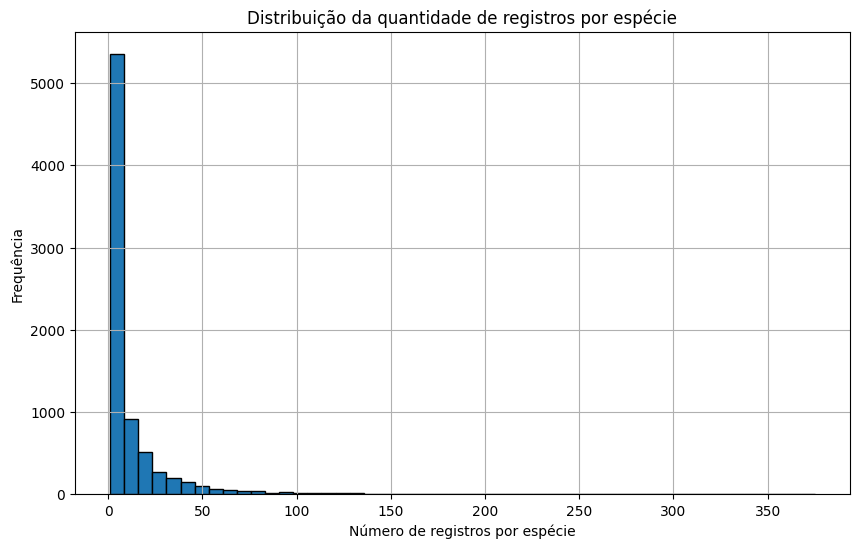

In [5]:
plt.figure(figsize=(10,6))
contagem_especies.plot(kind="hist", bins=50, edgecolor='black')
plt.title("Distribuição da quantidade de registros por espécie")
plt.xlabel("Número de registros por espécie")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

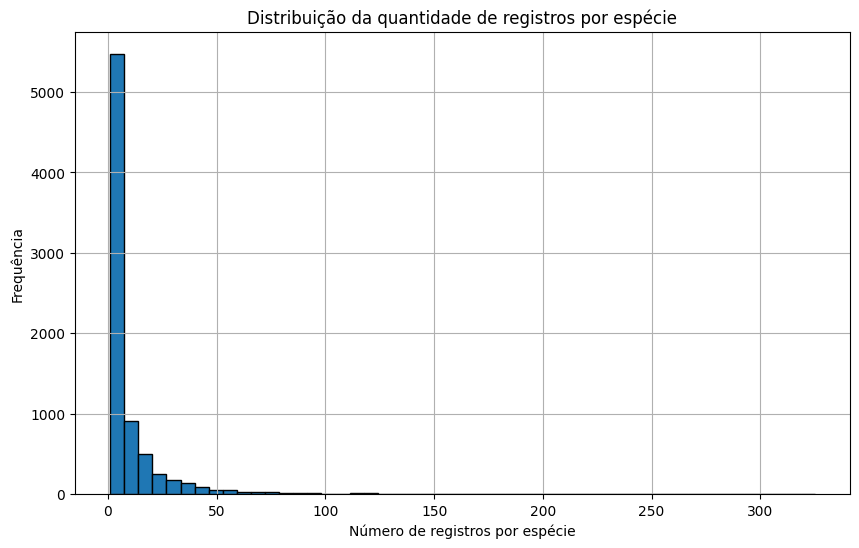

In [8]:
plt.figure(figsize=(10,6))
contagem_especies_unique.plot(kind="hist", bins=50, edgecolor='black')
plt.title("Distribuição da quantidade de registros por espécie")
plt.xlabel("Número de registros por espécie")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

In [6]:
limite = 30

especies_filtradas = contagem_especies_unique[contagem_especies_unique >= limite].index
df_plants = df_sem_duplicatas[df_sem_duplicatas['nome_cientifico'].isin(especies_filtradas)]



In [7]:
df_plants.to_csv("stage\dataset_plantae_rj_min_30.csv", index=False, sep=';', encoding='latin1')
contagem_especies_final= df_plants["nome_cientifico"].value_counts()
# Informações úteis
print("Registros originais:", len(df_sem_duplicatas))
print("Registros após filtragem (mínimo 30):", len(df_plants))
print("Registros removidos:", len(df_sem_duplicatas) - len(df_plants))

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Caio Cadete\AppData\Local\Temp\ipykernel_26968\1039146428.py:1: SyntaxWarning: invalid escape sequence '\d'
  df_plants.to_csv("stage\dataset_plantae_rj_min_30.csv", index=False, sep=';', encoding='latin1')


Registros originais: 77246
Registros após filtragem (mínimo 30): 37587
Registros removidos: 39659


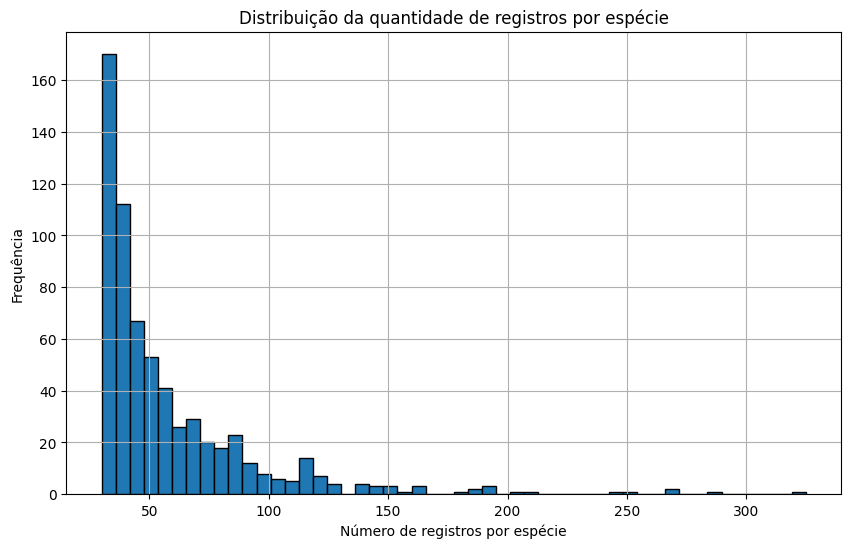

In [8]:
plt.figure(figsize=(10,6))
contagem_especies_final.plot(kind="hist", bins=50, edgecolor='black')
plt.title("Distribuição da quantidade de registros por espécie")
plt.xlabel("Número de registros por espécie")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

In [9]:
df_plants['latitude'] = df_plants['latitude'].astype(str).str.replace(',', '.')
df_plants['longitude'] = df_plants['longitude'].astype(str).str.replace(',', '.')

C:\Users\Caio Cadete\AppData\Local\Temp\ipykernel_26968\3400951838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plants['latitude'] = df_plants['latitude'].astype(str).str.replace(',', '.')
C:\Users\Caio Cadete\AppData\Local\Temp\ipykernel_26968\3400951838.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plants['longitude'] = df_plants['longitude'].astype(str).str.replace(',', '.')


In [10]:
# Latitude
df_plants['latitude'] = (
    df_plants['latitude']
    .astype(str)
    .str.strip()
    .replace(['', 'nan', 'NaN', 'None'], np.nan)
    .str.replace(',', '.', regex=False)
    .astype(float)
)

# Longitude
df_plants['longitude'] = (
    df_plants['longitude']
    .astype(str)
    .str.strip()
    .replace(['', 'nan', 'NaN', 'None'], np.nan)
    .str.replace(',', '.', regex=False)
    .astype(float)
)

# Remove linhas com lat/lon ausentes
df_plants = df_plants.dropna(subset=['latitude', 'longitude'])

C:\Users\Caio Cadete\AppData\Local\Temp\ipykernel_26968\1028760912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plants['latitude'] = (
C:\Users\Caio Cadete\AppData\Local\Temp\ipykernel_26968\1028760912.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plants['longitude'] = (


In [11]:
df_plants['latitude'] = df_plants['latitude'].astype(float)
df_plants['longitude'] = df_plants['longitude'].astype(float)

In [15]:
df_plants.columns
df_plants['latitude']

2       -22.855277
4       -21.652050
5       -22.953733
6       -22.943380
7       -22.462777
           ...    
94065   -22.355512
94066   -21.567222
94068   -22.591977
94072   -22.937867
94074   -22.900894
Name: latitude, Length: 36521, dtype: float64

In [16]:
df_plants['longitude']

2       -42.669722
4       -42.041222
5       -43.295193
6       -43.307220
7       -43.013333
           ...    
94065   -42.509673
94066   -41.061944
94068   -43.416613
94072   -43.174804
94074   -42.810493
Name: longitude, Length: 36521, dtype: float64

In [12]:
df_climasolotemp_rj = pd.read_csv("stage\dataset_climasolotemp_rj.csv", sep=";", encoding="latin1", dtype=str)


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Caio Cadete\AppData\Local\Temp\ipykernel_26968\176487861.py:1: SyntaxWarning: invalid escape sequence '\d'
  df_climasolotemp_rj = pd.read_csv("stage\dataset_climasolotemp_rj.csv", sep=";", encoding="latin1", dtype=str)


In [13]:
df_climasolotemp_rj['latitude']

0       -22.81
1       -22.81
2       -22.81
3       -22.81
4       -22.81
         ...  
1012     -22.5
1013    -22.55
1014    -22.63
1015    -21.71
1016    -22.51
Name: latitude, Length: 1017, dtype: object

In [19]:
df_climasolotemp_rj['longitude']

0       -41.98
1       -41.98
2       -41.98
3       -41.98
4       -41.98
         ...  
1012    -42.25
1013     -42.5
1014    -44.66
1015    -41.26
1016    -43.23
Name: longitude, Length: 1017, dtype: object

In [14]:
df_climasolotemp_rj = df_climasolotemp_rj.apply(pd.to_numeric)

In [15]:
# Supondo que df_plants e df_clima já estejam com latitude/longitude como float
# 1. Extrai as coordenadas como arrays NumPy
plant_coords = df_plants[['latitude', 'longitude']].to_numpy()
climasolotemp_coords = df_climasolotemp_rj[['latitude', 'longitude']].to_numpy()

In [16]:
# 2. Treina o modelo de vizinho mais próximo (mais rápido com 'ball_tree')
nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
nn.fit(climasolotemp_coords)

NearestNeighbors(algorithm='ball_tree', n_neighbors=1)

In [17]:
# 3. Para cada planta, encontra o ponto de clima mais próximo
distances, indices = nn.kneighbors(plant_coords)

In [18]:
# 4. Pega as linhas correspondentes do df_clima
df_climasolotemp_matched = df_climasolotemp_rj.iloc[indices.flatten()].reset_index(drop=True)

In [19]:
# 5. Remove lat/lon duplicadas do clima para evitar redundância
df_climasolotemp_matched = df_climasolotemp_matched.drop(columns=['latitude', 'longitude'])


In [20]:
# 6. Reseta o índice do df_plants também para garantir alinhamento
df_plants = df_plants.reset_index(drop=True)

In [21]:
# 9. Concatena os dois DataFrames (plantas + climasolotemp)
df_resultado = pd.concat([df_plants, df_climasolotemp_matched], axis=1)

In [22]:
# 10. Filtra por distância máxima aceitável (ex: 0.05 graus ≈ 5km)
dist_max = 0.05
df_resultado['distancia'] = distances.flatten()
df_resultado = df_resultado[df_resultado['distancia'] <= dist_max].drop(columns='distancia')

In [23]:
contagem_final = df_resultado["nome_cientifico"].value_counts()

In [24]:
contagem_final.describe()

count    643.000000
mean      31.472784
std       21.290319
min        5.000000
25%       18.000000
50%       26.000000
75%       38.000000
max      227.000000
Name: count, dtype: float64

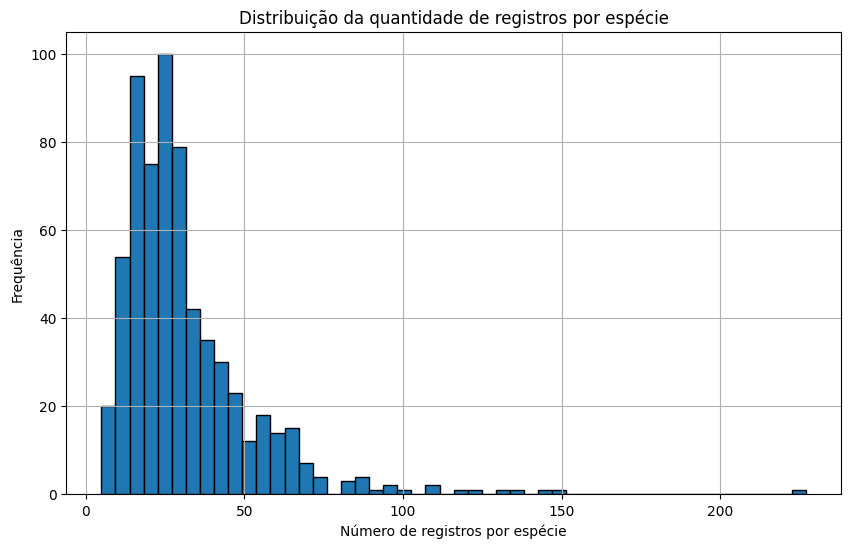

In [25]:
plt.figure(figsize=(10,6))
contagem_final.plot(kind="hist", bins=50, edgecolor='black')
plt.title("Distribuição da quantidade de registros por espécie")
plt.xlabel("Número de registros por espécie")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

In [26]:
# Filtra espécies com contagem >= limite

especies_final_filtradas = contagem_final[contagem_final >= limite].index

df_resultado = df_resultado[df_resultado['nome_cientifico'].isin(especies_final_filtradas)]
contagem_final = df_resultado["nome_cientifico"].value_counts()


In [27]:
contagem_final.describe()

count    256.000000
mean      49.437500
std       23.408143
min       30.000000
25%       34.000000
50%       42.000000
75%       57.000000
max      227.000000
Name: count, dtype: float64

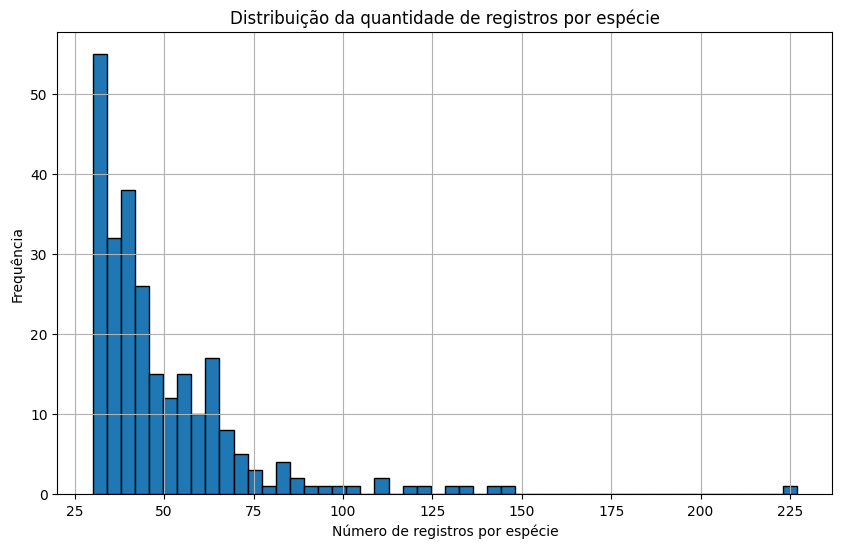

In [28]:
plt.figure(figsize=(10,6))
contagem_final.plot(kind="hist", bins=50, edgecolor='black')
plt.title("Distribuição da quantidade de registros por espécie")
plt.xlabel("Número de registros por espécie")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

In [29]:
df_resultado = df_resultado.drop_duplicates(subset=['nome_cientifico', 'latitude', 'longitude'])

In [30]:
# Verifica se houve duplicação depois do merge final
duplicatas = df_resultado.duplicated(subset=['nome_cientifico', 'latitude', 'longitude'])
print("Duplicatas após merge:", duplicatas.sum())


Duplicatas após merge: 0


In [32]:
print(df_resultado.groupby('nome_cientifico')['Sazonalidade_Temperatura'].nunique().sort_values())

nome_cientifico
Neoregelia cruenta            2
Begonia angulata              3
Adiantum obliquum             3
Opuntia monacantha            3
Aristolochia trilobata        3
                             ..
Dichorisandra thyrsiflora    21
Psychotria nuda              22
Hedychium coronarium         23
Psidium guajava              23
Eugenia uniflora             25
Name: Sazonalidade_Temperatura, Length: 256, dtype: int64


In [37]:
# 11. Salva o resultado final
df_resultado.to_csv('plantas_clima_rj_processado.csv', index=False, sep=';', encoding='latin1')